In [1]:
# Imports
from pathlib import Path
import torch
import matplotlib.pyplot as plt

from torch.utils.data import random_split, DataLoader, Subset

In [2]:
# Import own helpers
from vesuvius.data.vesuvius_train import VesuviusTrainDataset
from vesuvius.data.subset_with_transform import SubsetWithTransform
from vesuvius.transforms.volume import Compose, NormalizeVolume, CenterCrop3D

from vesuvius.training.train_epoch_3d import train_epoch_3d
from vesuvius.training.validate_epoch_3d import validate_epoch_3d

from vesuvius.models.unet3d_small import SmallUNet3D
from vesuvius.losses import BCELoss, DiceBCELoss

from vesuvius.visualization.sanity import sanity_visualization

In [3]:
# Root folder path
ROOT = Path("~/vesuvius-scroll-detection/data/raw/vesuvius").expanduser()

print("ROOT:", ROOT)

ROOT: /Users/chamu/vesuvius-scroll-detection/data/raw/vesuvius


In [4]:
# Device selection
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

print("Device:", device)

Device: mps


In [5]:
# Overfit configuration
batch_size = 1
seed = 0
n_overfit = 1
epochs = 60
lr = 3e-3

PATCH = (32, 96, 96)
print("PATCH:", PATCH)

PATCH: (32, 96, 96)


In [6]:
# Create a small loader
torch.manual_seed(seed)

# Base dataset (no transforms yet)
ds = VesuviusTrainDataset(ROOT)
print("Dataset size:", len(ds))

# Split
val_fraction = 0.15
n_total = len(ds)
n_val = max(1, int(val_fraction * n_total))
n_train = n_total - n_val

g = torch.Generator().manual_seed(seed)
train_subset, val_subset = random_split(ds, [n_train, n_val], generator=g)
print("Train subset:", len(train_subset))
print("Val subset:", len(val_subset))

Dataset size: 806
Train subset: 686
Val subset: 120


In [7]:
# Overfit transform: deterministic
tf = Compose([
    CenterCrop3D(PATCH),
    NormalizeVolume(eps=1e-6),
])

train_ds = SubsetWithTransform(train_subset, transform=tf)

# Tiny overfit subset (train == val)
tiny_ds = Subset(train_ds, list(range(n_overfit)))

tiny_train_loader = DataLoader(tiny_ds, batch_size=batch_size, shuffle=True, num_workers=0)
tiny_val_loader   = DataLoader(tiny_ds, batch_size=batch_size, shuffle=False, num_workers=0)

imgs, masks, sids = next(iter(tiny_train_loader))
print("imgs:", tuple(imgs.shape), imgs.dtype)
print("masks:", tuple(masks.shape), masks.dtype, "unique:", torch.unique(masks))
print("sids:", sids)

imgs: (1, 1, 32, 96, 96) torch.float32
masks: (1, 1, 32, 96, 96) torch.float32 unique: tensor([0., 1., 2.])
sids: ('1693625989',)


In [8]:
# Initialising model
torch.manual_seed(seed)

model = SmallUNet3D(in_channels=1, base_channels=8).to(device)

In [9]:
# Loss function + Optimizer
loss_fn = DiceBCELoss(w_bce=0.5, w_dice=0.5)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.0)

print("params:", sum(param.numel() for param in model.parameters()))

params: 85177


In [10]:
# Train loop
for epoch in range(1, epochs + 1):
    train_loss = train_epoch_3d(model, tiny_train_loader, loss_fn, optimizer, device)
    val_loss, val_metrics = validate_epoch_3d(model, tiny_val_loader, loss_fn, device)

    if epoch == 1 or epoch % 5 == 0:
        dice = val_metrics.get("dice", None)
        if dice is None:
            print(f"epoch {epoch:03d} | train_loss={train_loss:.6f} | val_loss={val_loss:.6f} | metrics={val_metrics}")
        else:
            print(f"epoch {epoch:03d} | train_loss={train_loss:.6f} | val_loss={val_loss:.6f} | dice={dice:.4f}")

epoch 001 | train_loss=0.660532 | val_loss=0.693617 | dice=0.0000
epoch 005 | train_loss=0.570813 | val_loss=0.679839 | dice=0.0000
epoch 010 | train_loss=0.323711 | val_loss=0.610665 | dice=0.0000
epoch 015 | train_loss=0.206945 | val_loss=0.370538 | dice=0.3303
epoch 020 | train_loss=0.159590 | val_loss=0.176573 | dice=0.4916
epoch 025 | train_loss=0.128606 | val_loss=0.130390 | dice=0.5414
epoch 030 | train_loss=0.107680 | val_loss=0.086024 | dice=0.6025
epoch 035 | train_loss=0.091367 | val_loss=0.068536 | dice=0.6301
epoch 040 | train_loss=0.080685 | val_loss=0.064140 | dice=0.6846
epoch 045 | train_loss=0.076385 | val_loss=0.063256 | dice=0.7114
epoch 050 | train_loss=0.066710 | val_loss=0.061637 | dice=0.7219
epoch 055 | train_loss=0.073310 | val_loss=0.080177 | dice=0.6791
epoch 060 | train_loss=0.073256 | val_loss=0.062896 | dice=0.7430


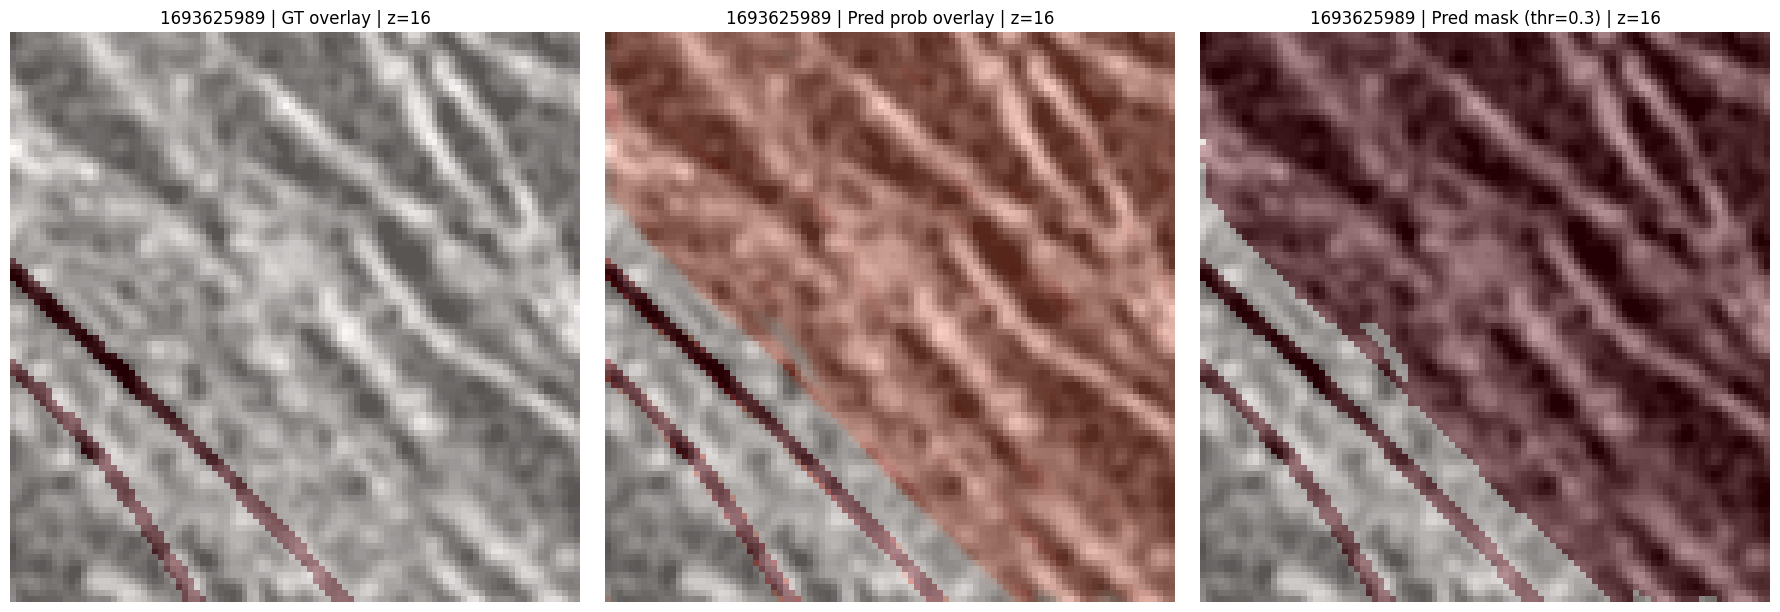

In [11]:
# Sanity visualisation
sanity_visualization(
    model,
    tiny_val_loader,
    device,
    threshold=0.3,   # tweak freely
)